<a href="https://colab.research.google.com/github/RiniVarghese/NLP_Ticket_Classification/blob/Master/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

Mounted at /content/drive


## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from pprint import pprint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file
jsonFile = open("/content/drive/MyDrive/TicketClassification_Assign/complaints-2021-05-14_08_16.json")

# returns JSON object as
# a dictionary
data = json.load(jsonFile)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
df.shape

(78313, 22)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
#print the column names
df.columns


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [8]:
#Assign new column names
df.columns = [re.sub("^_(source.)?", "", column_name) for column_name in df.columns]
print(df.columns)


Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [9]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [10]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened'] == ''] = np.nan

In [12]:
df.isna().sum()

index                        57241
type                         57241
id                           57241
score                        57241
tags                         74497
zip_code                     61886
complaint_id                 57241
issue                        57241
date_received                57241
state                        57384
consumer_disputed            57241
product                      57241
company_response             57241
company                      57241
submitted_via                57241
date_sent_to_company         57241
company_public_response      78311
sub_product                  59350
timely                       57241
complaint_what_happened      57241
sub_issue                    65417
consumer_consent_provided    57241
dtype: int64

In [13]:
#Remove all rows where complaints column is nan
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x: np.nan if (isinstance(x, str) and re.search("^[\s]*$", x)) else x)



In [14]:
df = df[~(df["complaint_what_happened"].isnull())]
df.shape

(21072, 22)

In [15]:
df.isna().sum()

index                            0
type                             0
id                               0
score                            0
tags                         17256
zip_code                      4645
complaint_id                     0
issue                            0
date_received                    0
state                          143
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      21070
sub_product                   2109
timely                           0
complaint_what_happened          0
sub_issue                     8176
consumer_consent_provided        0
dtype: int64

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text



In [17]:

# Test above method
sample = df.complaint_what_happened.sample().values[0]
print(sample)
print("---------------------------------")
cleanSample = clean_text(sample)
print(cleanSample)

Buyer for my townhouse has outstanding credit applied for conventional loan with XXXX on XX/XX/2016. He was approved immediately for the loan. Our closing date was set for XXXX XXXX, then XXXX XXXX, then XXXX XXXX, XXXX XXXX, XXXX XXXX, XXXX XXXX, and now XXXX XXXX. Chase has not explained why and refuses to return calls to me and the buyer. This delay has now caused hardship on several different people.
---------------------------------
buyer for my townhouse has outstanding credit applied for conventional loan with xxxx on  he was approved immediately for the loan our closing date was set for xxxx xxxx then xxxx xxxx then xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx and now xxxx xxxx chase has not explained why and refuses to return calls to me and the buyer this delay has now caused hardship on several different people


In [18]:
#Write your function to Lemmatize the texts
def lemmatize_text(complaint) :
  doc = nlp(str(complaint))
  lemma_complaint = " ".join([token.lemma_ for token in doc])
  return lemma_complaint


In [19]:
# Test above method
print(cleanSample)
print("---------------------------------")
lemmatizedText = lemmatize_text(cleanSample)
print(lemmatizedText)

buyer for my townhouse has outstanding credit applied for conventional loan with xxxx on  he was approved immediately for the loan our closing date was set for xxxx xxxx then xxxx xxxx then xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx and now xxxx xxxx chase has not explained why and refuses to return calls to me and the buyer this delay has now caused hardship on several different people
---------------------------------
buyer for my townhouse have outstanding credit apply for conventional loan with xxxx on   he be approve immediately for the loan our closing date be set for xxxx xxxx then xxxx xxxx then xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx and now xxxx xxxx chase have not explain why and refuse to return call to I and the buyer this delay have now cause hardship on several different people


In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: clean_text(x)))
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: lemmatize_text(x['complaint_what_happened']), axis=1)
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [21]:
df_clean.shape

(21072, 2)

In [22]:
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [23]:
#Write your function to extract the POS tags
# Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


from textblob import TextBlob

def get_pos_tag(text):
    blob = TextBlob(text)
    nouns = [word for (word, tag) in blob.tags if tag.startswith('NN')]
    return " ".join(nouns)


In [24]:
df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaint'].apply(get_pos_tag)

In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.shape

(21072, 3)

In [26]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




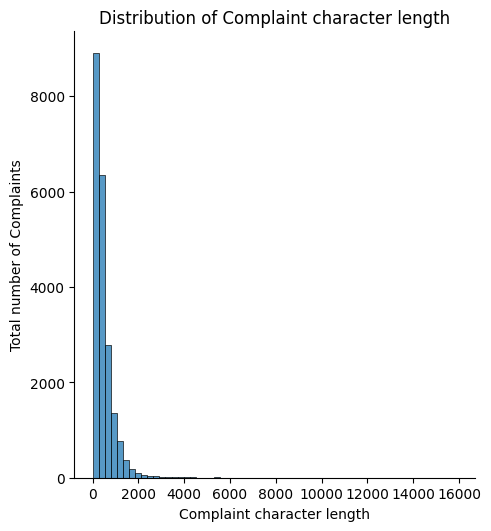

In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length

complaint_len = [len(char) for char in df_clean['complaint_POS_removed']]

# Visualizing the data

sns.displot(complaint_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [28]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS



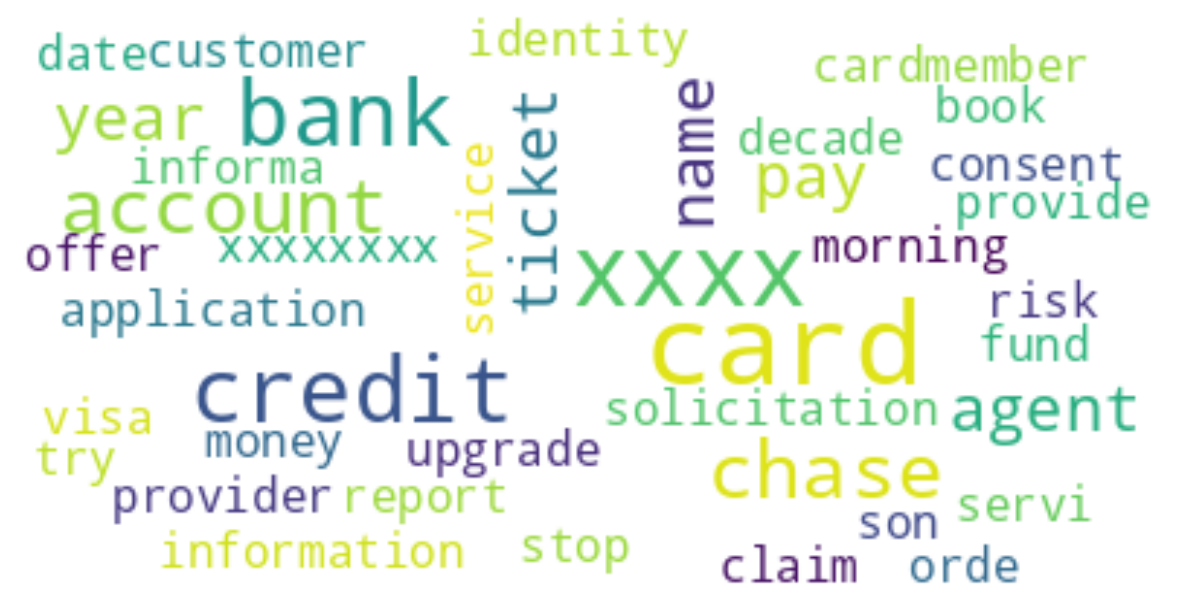

In [29]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=40, max_words=40,
                      background_color="white", random_state=100,
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
# Top 40 words
print(list(wordcloud.words_.keys())[:40])

['card', 'xxxx', 'bank', 'credit', 'chase', 'account', 'name', 'agent', 'ticket', 'pay', 'year', 'morning', 'stop', 'cardmember', 'service', 'upgrade', 'date', 'information', 'orde', 'report', 'application', 'identity', 'consent', 'servi', 'try', 'book', 'offer', 'informa', 'son', 'fund', 'money', 'customer', 'decade', 'solicitation', 'xxxxxxxx', 'visa', 'provider', 'claim', 'risk', 'provide']


In [31]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [32]:
# Defining a function to get the top n words(unigrams)

def get_top_ngrams(text, n= None, ngram=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
    bagofwords = vec.transform(text)
    sum_words = bagofwords.sum(axis=0)
    word_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return word_frequency[:n]

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

top_30_words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30_words, columns=['unigram', 'count'])

fig = go.Figure([go.Bar(x=df_unigram['unigram'], y=df_unigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 unigrams in the cleaned complaint text'))
fig.show()

In [34]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,xxxx,149118
1,account,47530
2,chase,47063
3,credit,34148
4,card,29310
5,bank,28403
6,xxxxxxxx,22705
7,payment,21166
8,time,16021
9,charge,15018


In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30_words, columns=['bigram', 'count'])

fig = go.Figure([go.Bar(x=df_bigram['bigram'], y=df_bigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 bigram in the cleaned complaint text'))
fig.show()

In [36]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,xxxx xxxx,69018
1,credit card,12781
2,credit report,3946
3,xxxxxxxx xxxx,3219
4,xxxx chase,3138
5,account xxxx,3108
6,customer service,3080
7,chase bank,2888
8,xxxx xxxxxxxx,2814
9,chase credit,2805


In [37]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30_words, columns=['trigram', 'count'])

fig=go.Figure([go.Bar(x=df_trigram['trigram'], y=df_trigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 trigram in the cleaned complaint text'))
fig.show()

In [38]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,xxxx xxxx xxxx,35316
1,chase credit card,1921
2,xxxxxxxx xxxx xxxx,1589
3,xxxx xxxx xxxxxxxx,1299
4,xxxx xxxx chase,1290
5,account xxxx xxxx,1257
6,xxxx credit card,1049
7,bank xxxx xxxx,1004
8,credit card account,1004
9,credit card company,988


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [39]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [40]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service ask...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxxxxxx xxxx visa credit card provider claim ...,visa credit card provider claim purchase pro...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [41]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [42]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [43]:
dtm

<21072x7428 sparse matrix of type '<class 'numpy.float64'>'
	with 648941 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [44]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [45]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [46]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7428

In [47]:
ttm = nmf_model.components_

In [48]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = ttm[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,chase,dispute,merchant,fraud,claim,purchase,service,time,statement,refund,company
Topic 5,loan,mortgage,home,chase,modification,property,year,letter,rate,time,document,bank,house,foreclosure,sale


Observation
Based on the words for each topic we are able to label them on basis of the product/services:

Topic 1 - Bank account service

Topic 2 - Prepaid Card/Credit Card

Topic 3 - Balance/Statement Enquiry(Others)

Topic 4 - Theft/Dispute Reports

Topic 5 - Loans/Mortgages

In [49]:
topic_results = nmf_model.transform(dtm)
df_clean['Topic'] = topic_results.argmax(axis=1)
df_clean.head()


,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service ask...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [50]:
df_clean.shape

(21072, 5)

In [52]:
#Print the first 5 Complaint for each of the Topics
df_clean_top5=df_clean.groupby('Topic').head(5)
df_clean_top5.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service ask...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank xxxx code bonus xxxxxxxx term eve...,account bank code bonus term everything acco...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others



In [53]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [54]:
df_clean.shape

(21072, 5)

In [55]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service ask...,Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [56]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [57]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service ask...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [58]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened', 'Topic']]

In [59]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [60]:

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)



In [61]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print('X_Train',X_train.shape)
print('y_train',y_train.shape)
print('X_Test',X_test.shape)
print('y_test',y_test.shape)

X_Train (15804, 33599)
y_train (15804,)
X_Test (5268, 33599)
y_test (5268,)


Write your code here to build any 3 models and evaluate them using the required metrics

# **Model 1 - Logistic Regression**

In [63]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)


LogisticRegression(solver='liblinear')

In [64]:
lr.score(X_test, y_test)

0.9143887623386484

In [65]:
y_pred = lr.predict(X_test)

In [66]:
# Printing Confusion Matrix

print(confusion_matrix(y_test, y_pred))

[[1233   22    3   29   15]
 [  22 1189    5   47    9]
 [  20   24  464   22   27]
 [  72   44    8 1078   19]
 [  22   22    6   13  853]]


In [67]:
# Creating the target list

target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [68]:
# Printing Classification Report
print(classification_report(y_test, y_pred, target_names = target))

                            precision    recall  f1-score   support

     Bank account services       0.90      0.95      0.92      1302
Credit card / Prepaid card       0.91      0.93      0.92      1272
                    Others       0.95      0.83      0.89       557
   Theft/Dispute reporting       0.91      0.88      0.89      1221
           Mortgages/loans       0.92      0.93      0.93       916

                  accuracy                           0.91      5268
                 macro avg       0.92      0.91      0.91      5268
              weighted avg       0.92      0.91      0.91      5268



Overall accuracy of the Logistic Regression model is 91%. Precision and Recall is around 92% and 91% respectively

## **Model 2 : Decision Trees**

In [69]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [70]:
dt.score(X_test, y_test)

0.7862566438876234

Model Evaluation

In [71]:

# Making predictions on test data
y_pred = dt.predict(X_test)

In [72]:
# Printing Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1059   58   41   95   49]
 [  75 1032   30   94   41]
 [  27   38  419   36   37]
 [ 126  126   28  889   52]
 [  52   33   45   43  743]]


In [73]:
# Printing the Classification Report
print(classification_report(y_test, y_pred, target_names = target))

                            precision    recall  f1-score   support

     Bank account services       0.79      0.81      0.80      1302
Credit card / Prepaid card       0.80      0.81      0.81      1272
                    Others       0.74      0.75      0.75       557
   Theft/Dispute reporting       0.77      0.73      0.75      1221
           Mortgages/loans       0.81      0.81      0.81       916

                  accuracy                           0.79      5268
                 macro avg       0.78      0.78      0.78      5268
              weighted avg       0.79      0.79      0.79      5268



Overall accuracy of the Model is 79%

## **Model 3: Random Forest**

In [74]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [75]:
rf.score(X_test, y_test)

0.816628701594533

Model Evaluation

In [76]:
y_pred = rf.predict(X_test)

In [77]:
# Printing Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1195   45    4   45   13]
 [  62 1084    4  108   14]
 [  71   73  270   64   79]
 [ 159   81    8  958   15]
 [  50   43    5   23  795]]


In [78]:
# Printing the Classification Report
print(classification_report(y_test, y_pred, target_names = target))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.92      0.84      1302
Credit card / Prepaid card       0.82      0.85      0.83      1272
                    Others       0.93      0.48      0.64       557
   Theft/Dispute reporting       0.80      0.78      0.79      1221
           Mortgages/loans       0.87      0.87      0.87       916

                  accuracy                           0.82      5268
                 macro avg       0.84      0.78      0.79      5268
              weighted avg       0.82      0.82      0.81      5268



 Accuracy of the overall Random Forest Model is 82%

The model performs well for "Bank account services" and "Credit card / Prepaid card" with high precision, recall, and F1-score.

The class "Others" has a high precision (93%) but a low recall (48%),

## **Model 4 : Naive Bayes**

In [79]:
clf = MultinomialNB().fit(X_train, y_train)

In [80]:
clf.score(X_test, y_test)

0.7179195140470767

In [81]:
y_pred = clf.predict(X_test)

In [82]:
print(confusion_matrix(y_test, y_pred))

[[1182   59    0   50   11]
 [ 154  955    0  154    9]
 [ 155  176    5  130   91]
 [ 214   52    0  950    5]
 [ 114   87    0   25  690]]


In [83]:
print(classification_report(y_test, y_pred, target_names = target))

                            precision    recall  f1-score   support

     Bank account services       0.65      0.91      0.76      1302
Credit card / Prepaid card       0.72      0.75      0.73      1272
                    Others       1.00      0.01      0.02       557
   Theft/Dispute reporting       0.73      0.78      0.75      1221
           Mortgages/loans       0.86      0.75      0.80       916

                  accuracy                           0.72      5268
                 macro avg       0.79      0.64      0.61      5268
              weighted avg       0.76      0.72      0.68      5268



Accuracy score - 72%
The model seems to perform well for "Bank account services," "Credit card / Prepaid card," and "Theft/Dispute reporting" classes.

The "Others" class has extremely low recall, suggesting that the model struggles to identify instances of this class, potentially leading to false negatives.

## **Model inference**

## **Conclusion**

We have created Four supervised model to predict new complaints to the relevent Topics-

Random Forest Classifier

1.   Logistic Regression
2.   Decision Tree Classifier
3.   Random Forest
4.   Naive Bayes



**Results**

**Logistic Regression**

. Overall accuracy of the Logistic Regression model is 91%

. Precision and Recall is also at 92% and 91 % each which makes this a very good
model.

**Decision Tree Classifier**

. The overall accuracy of the Decision Tree model is 79%.

. The precision and recall are 78% .

**Random Forest Classifier**

. Accuracy of the overall Random Forest Model is 82%

. Precision and recall are 84% and 78% respectively.

. We can see that the model overfits for "Others" category for Precision.

**Naive Bayes**

 Overall Accuracy of the model is 72%
 Precision and Recall are at 79% and 64% .





# **Final Conclusion**

Logistic Regression is the best model with an accuracy of 91% with Precision and Recall as 92% and 91% respectively when compared to the other supervised models.

# **Model Inference**

In [84]:
# Function to predict a topic for given text
def predict_topic(text):

    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [85]:
df_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_new

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [86]:
df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))
df_new

,complaints,predicted topic
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Credit card or prepaid card
5,I need to know the number of bank branches and...,Bank Account services
